In [14]:
import os
import sys
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tqdm import tqdm_notebook
from math import ceil

import warnings
warnings.filterwarnings('ignore')

### Data

In [15]:
transactions = pd.read_csv("data_archive/transactions.csv")
accounts = pd.read_csv("data_archive/accounts.csv")
transactions = transactions.head(4000)

In [16]:
transactions.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
0,1,33,43,CREDIT,979.21,2010-01-01T00:00:00Z,False,-1
1,2,16,83,CREDIT,302.33,2010-01-01T00:00:00Z,False,-1
2,3,50,62,WIRE,234.08,2010-01-01T00:00:00Z,True,0
3,4,28,35,DEPOSIT,789.99,2010-01-01T00:00:00Z,False,-1
4,5,97,93,DEPOSIT,394.91,2010-01-01T00:00:00Z,False,-1


In [17]:
accounts.head()

,acct_id,dsply_nm,type,acct_stat,acct_rptng_crncy,prior_sar_count,branch_id,open_dt,close_dt,initial_deposit,...,street_addr,city,state,country,zip,gender,birth_date,ssn,lon,lat
0,0,C_0,SAV,A,USD,False,1,2010-01-01T00:00:00Z,4747-11-29T00:00:00Z,92221.09,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
1,1,C_1,SAV,A,USD,False,1,2010-01-01T00:00:00Z,4747-11-29T00:00:00Z,87897.72,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C_2,SAV,A,USD,False,1,2010-01-01T00:00:00Z,4747-11-29T00:00:00Z,71028.58,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C_3,SAV,A,USD,False,1,2010-01-01T00:00:00Z,4747-11-29T00:00:00Z,62945.84,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C_4,SAV,A,USD,False,1,2010-01-01T00:00:00Z,4747-11-29T00:00:00Z,75563.74,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def processing_dataframes():
    
    print("Dropping NaN columns")
    accounts.dropna(axis=1, how='all', inplace=True)
    
    print("Renaming columns wrt to Stellar Config")
    transactions.columns  = ['tran_id', 'source', 'target', 'tx_type', 'weight',
       'tran_timestamp', 'is_sar', 'alert_id']
    
    # Label encoder performing encoding for all objects
    print("Label encoding categorical features")
    
    #transaction
    le = LabelEncoder()
    for col in transactions.columns:
        if transactions[col].dtype == "O":
            transactions[col] = le.fit_transform(transactions[col].astype(str))  
    #accounts     
    le = LabelEncoder()
    for col in accounts.columns:
        if accounts[col].dtype == "O":
            accounts[col] = le.fit_transform(accounts[col].astype(str))   
            
            
    scaler = MinMaxScaler()
    transactions['weight'] = scaler.fit_transform(transactions['weight'].values.reshape(-1,1))
    print('\n')
    print("--> Account df done!")
    display(accounts.head())
    print("--> Transaction df done!")
    display(transactions.head())    
processing_dataframes()

Dropping NaN columns
Renaming columns wrt to Stellar Config
Label encoding categorical features


--> Account df done!


,acct_id,dsply_nm,type,acct_stat,acct_rptng_crncy,prior_sar_count,branch_id,open_dt,close_dt,initial_deposit,tx_behavior_id,bank_id,country
0,0,0,0,0,0,False,1,0,0,92221.09,1,3,0
1,1,1,0,0,0,False,1,0,0,87897.72,1,3,0
2,2,12,0,0,0,False,1,0,0,71028.58,1,3,0
3,3,23,0,0,0,False,1,0,0,62945.84,1,3,0
4,4,34,0,0,0,False,1,0,0,75563.74,1,3,0


--> Transaction df done!


,tran_id,source,target,tx_type,weight,tran_timestamp,is_sar,alert_id
0,1,33,43,0,0.892179,0,False,-1
1,2,16,83,0,0.206196,0,False,-1
2,3,50,62,3,0.137028,0,True,0
3,4,28,35,1,0.700415,0,False,-1
4,5,97,93,1,0.300021,0,False,-1


### Defining class for graph Convolutional Networks
`Helper Functions`

In [19]:
from sklearn.metrics import roc_auc_score

def one_hot_encode(y):
    mods = len(np.unique(y))
    y_enc = np.zeros((y.shape[0], mods))
    
    for i in range(y.shape[0]):
        y_enc[i, y[i]] = 1
    return y_enc

class GraphConvolutionNetwork():
    
    def __init__(self, node_dim=2, graph_dim=2, nb_classes=2, nmax=15, alpha=0.025):

        self.node_dim = node_dim
        self.graph_dim = graph_dim
        self.nb_classes = nb_classes
        self.nmax = nmax
        self.alpha = alpha
        
        self.build_model()
        
    def build_model(self):
        self.adjs = tf.placeholder(tf.float32, shape=[None, self.nmax, self.nmax])
        self.embeddings = tf.placeholder(tf.float32, shape=[None, self.nmax, self.node_dim])
        self.targets = tf.placeholder(tf.float32, shape=[None, self.nb_classes])
        
        A1 = tf.Variable(tf.random_normal([self.graph_dim, self.node_dim], seed=None))
        B1 = tf.Variable(tf.random_normal([self.graph_dim, self.node_dim]))
        W  = tf.Variable(tf.random_normal([self.graph_dim, self.nb_classes]))
        
        M1 = tf.einsum('adc,adb->abc', self.embeddings, self.adjs)
        H1 = tf.nn.relu(tf.tensordot(M1, A1, (2, 1)) + tf.tensordot(self.embeddings, B1, (2, 1)))
        G1 = tf.reduce_mean(H1, 1)
        
        Y_OUT = tf.matmul(G1,W)
        cost = tf.losses.softmax_cross_entropy(self.targets, Y_OUT)
        
        self.predictions = tf.argmax(Y_OUT, 1)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.alpha)
        self.train = optimizer.minimize(cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def fit(self, adj, embds, y, epochs=20, batch_size=10, shuffle=True):
        self.scores = []
        y_enc = one_hot_encode(y)
        minibatches = ceil(len(adj) / batch_size)
        
        j = 0
        for i in range(epochs):
            INDS = np.array(range(len(adj)))
            
            if shuffle:
                idx = np.random.permutation(y.shape[0]) 
                INDS = INDS[idx]
                
            mini = np.array_split(INDS, minibatches)
            
            for inds in mini:
                j+=1
                sys.stderr.write('\rEpoch: %d/%d' % (j, epochs*minibatches))
                sys.stderr.flush()
                self.sess.run(self.train, feed_dict={self.adjs:adj[inds], self.embeddings:embds[inds], 
                                                self.targets:y_enc[inds]})                
            self.scores.append(self.score(adj, embds, y))
            #
    def predict(self, adj, embds):
        return self.sess.run(self.predictions, feed_dict={self.adjs:adj, self.embeddings:embds})
    
    def score(self, adj, embds,y):
        y_ = self.predict(adj, embds)
        return 100*(y==y_).mean()

    def auc_score(self, adj, embds,y):
        from sklearn.metrics import roc_auc_score
        y_ = self.predict(adj, embds)
        return roc_auc_score(y,y_)
    
class MultiLaplacianGCN():
    
    def __init__(self, node_dim=2, graph_dim=[3,3], nb_classes=2, nmax=15, alpha=0.025):

        self.graph_dims = [node_dim] + graph_dim
        self.n_layers = len(graph_dim)
        self.nb_classes = nb_classes
        self.nmax = nmax
        self.alpha = alpha
        
        self.build_model()
        
    def build_model(self):
        self.adjs = tf.placeholder(tf.float32, shape=[None, self.nmax, self.nmax])
        self.targets = tf.placeholder(tf.float32, shape=[None, self.nb_classes])
        
        self.A = {i+1: tf.Variable(tf.random_normal([self.graph_dims[i+1], self.graph_dims[i]])) \
             for i in range(self.n_layers)}
        self.B = {i+1: tf.Variable(tf.random_normal([self.graph_dims[i+1], self.graph_dims[i]])) \
             for i in range(self.n_layers)}
        self.W  = tf.Variable(tf.random_normal([self.graph_dims[-1], self.nb_classes]))
        
        
        self.M, self.H, self.G = {}, {}, {}
        
        self.H[0] = tf.placeholder(tf.float32, shape=[None, self.nmax, self.graph_dims[0]])
        
        for i in range(1, self.n_layers+1):
        
            self.M[i] = tf.einsum('adc,adb->abc', self.H[i-1], self.adjs)
            self.H[i] = tf.nn.relu(tf.tensordot(self.M[i], self.A[i], (2, 1)) 
                                   + tf.tensordot(self.H[i-1], self.B[i], (2, 1)))
            self.G[i] = tf.reduce_mean(self.H[i], 1)
        
        Y_OUT = tf.matmul(self.G[self.n_layers], self.W)
        cost = tf.losses.softmax_cross_entropy(self.targets, Y_OUT)
        
        self.predictions = tf.argmax(Y_OUT, 1)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.alpha)
        self.train = optimizer.minimize(cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def fit(self, adj, embds, y, epochs=20, batch_size=10, shuffle=True):
        self.scores = []
        minibatches = ceil(len(adj) / batch_size)
        
        y_enc = one_hot_encode(y)
        
        j = 0
        for i in range(epochs):
            INDS = np.array(range(len(adj)))
            
            if shuffle:
                idx = np.random.permutation(y.shape[0]) 
                INDS = INDS[idx]
                
            mini = np.array_split(INDS, minibatches)
            
            for inds in mini:
                j+=1
                sys.stderr.write('\rEpoch: %d/%d' % (j, epochs*minibatches))
                sys.stderr.flush()
                self.sess.run(self.train, feed_dict={self.adjs:adj[inds], self.H[0]:embds[inds], 
                                                self.targets:y_enc[inds]})
                
            self.scores.append(self.score(adj, embds, y))
            
        
        
    def predict(self, adj, embds):
        return self.sess.run(self.predictions, feed_dict={self.adjs:adj, self.H[0]:embds})
    
    def score(self, adj, embds,y):
        y_ = self.predict(adj, embds)
        return 100*(y==y_).mean()
    
    def auc_score(self, adj, embds,y):
        from sklearn.metrics import roc_auc_score
        y_ = self.predict(adj, embds)
        return roc_auc_score(y,y_)

In [20]:
graphs_aml = []
for idx, row in tqdm_notebook(transactions.iterrows(),total=transactions.shape[0]):
    source = row['source']
    tran_id = row['tran_id']
    df = transactions[(transactions['source']==source)]
    nodes_list = list(set(df['source'].tolist() + df['target'].tolist()))
    tmp_node = accounts[accounts['acct_id'].isin(nodes_list)].set_index('acct_id')
    graph = nx.from_pandas_edgelist(df, 'source', 'target', ['weight', 'tx_type'])
    graphs_aml.append(graph)
graphs = graphs_aml

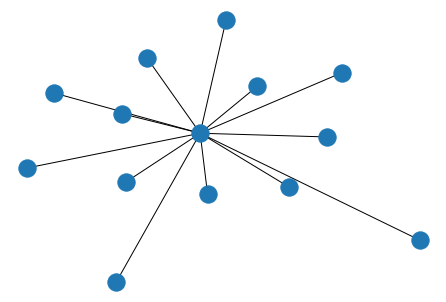

In [21]:
nx.draw(graphs[993])

In [22]:
def get_graph_features(G, all_embds, nmax=15):
    n = len(G.nodes())
    
    node2id = {node:i for i, node in enumerate(G.nodes())}
    id2node = {i:node for node,i in node2id.items()}

    adj = np.zeros((nmax,nmax))
    embds = np.zeros((nmax, all_embds.shape[1]))

    for i in G.nodes():
        embds[node2id[i]] = all_embds[i]
        for j in G.neighbors(i):
            adj[node2id[j],node2id[i]] = 1
    
    return adj, embds

In [23]:
EMBED_DIM = 5
NB_SAMPLES = transactions.shape[0]
VOCAB_SIZE = 325
MAX_LENGTH = 10
NB_CLASSES = 2
# PROBAS = [0.3, 0.4, 0.55]
# CENTERS  =[0.1, 0.15, 0.2]
SHARE = .50
GRAPH_DIM = 10


# Relation and Target data for feeding into Neural Network
graphs = graphs_aml
y = transactions['is_sar'].astype('uint')

In [24]:
embds = np.random.normal(size = (accounts.shape[0],EMBED_DIM))
embds.shape

(100, 5)

In [25]:
Adjs, Ids = [], []
for graph in graphs:
    adj, embds_g = get_graph_features(graph, embds, nmax=VOCAB_SIZE)
    Adjs.append(adj)
    Ids.append(embds_g)

In [26]:
pd.DataFrame(y)['is_sar'].value_counts()

0    3956
1      44
Name: is_sar, dtype: int64

### Training Data Preparation

In [27]:
ADJ = np.array(Adjs)
ID = np.array(Ids)

CUT = int(NB_SAMPLES * SHARE)
ADJ_train, y_train, ADJ_test, y_test = ADJ[:CUT], y[:CUT], ADJ[CUT:], y[CUT:]
ID_train, ID_test = ID[:CUT], ID[CUT:]

### GCN Training

In [29]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
# Accomodating change for tensorflow 1.x behaviour 

# Running GCN
model = GraphConvolutionNetwork(node_dim=EMBED_DIM, graph_dim=GRAPH_DIM, nb_classes=NB_CLASSES, 
             nmax=VOCAB_SIZE, alpha=0.025)
model.fit(ADJ_train, ID_train, y_train, epochs=10, batch_size=32)

Epoch: 630/630

### Results GCN

In [30]:
# Train-test results
train_score = model.score(ADJ_train, ID_train, y_train)
test_score = model.score(ADJ_test, ID_test, y_test)
print(f"Training score : {train_score}")
print(f"Test score : {test_score}")

Training score : 98.0
Test score : 99.8


In [31]:
train_score = model.auc_score(ADJ_train, ID_train, y_train)
test_score = model.auc_score(ADJ_test, ID_test, y_test)
print(f"Training ROC AUC : {train_score}")
print(f"Test ROC AUC : {test_score}")

Training ROC AUC : 0.5
Test ROC AUC : 0.5


### Inference GCN

In [62]:
ndf = transactions[transactions.is_sar == True].sample(1)
src, dst = ndf.source.iloc[0], ndf.target.iloc[0]

In [63]:
def find_all_traversals(df, st_node):
    traversal = []
    visited = set()
    inds = set()

    def backtract(node, ind = None):

        traversal.append(node)
        visited.add(node)
        if ind is not None:
            inds.add(ind)

        ndf = df[df.target == node]
        for ind, neighbour_df in ndf.iterrows():
            neighbour = neighbour_df.source
            if neighbour not in visited:
                backtract(neighbour, ind)
    
    backtract(st_node)
    
    return traversal, list(inds)

In [64]:
_, inds = find_all_traversals(transactions, dst)

In [65]:
transactions.iloc[inds]

,tran_id,source,target,tx_type,weight,tran_timestamp,is_sar,alert_id
1,2,16,83,0,0.206196,0,False,-1
4,5,97,93,1,0.300021,0,False,-1
5,6,79,95,0,0.104142,0,True,2
7,8,29,28,0,0.117297,0,True,1
8,9,9,23,0,0.484722,0,False,-1
...,...,...,...,...,...,...,...,...
459,460,15,24,3,0.716944,32,False,-1
1514,1515,96,4,0,0.292370,104,False,-1
1002,1003,85,91,1,0.706607,69,False,-1
2040,2041,68,62,1,0.137028,140,True,0


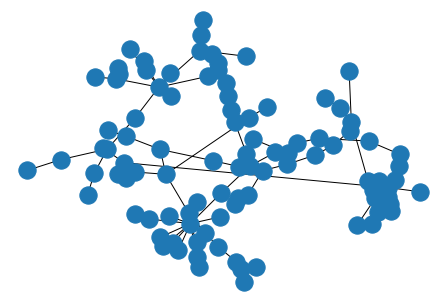

In [66]:
payload = {
    "source" : 98,
    "target" : 24,
    "weight" : 0.2,
    "tx_type": 3,
}
inference_df = transactions.iloc[inds][['source','target','weight','tx_type']].copy()
inference_df.append(payload,ignore_index=True)
#df = inference_df[(inference_df['source']==payload['source'])]
df = inference_df.copy()
nodes_list = list(set(df['source'].tolist() + df['target'].tolist()))
tmp_node = accounts[accounts['acct_id'].isin(nodes_list)].set_index('acct_id')
graph = nx.from_pandas_edgelist(df, 'source', 'target', ['weight', 'tx_type'])
nx.draw(graph)

In [67]:
adj, embds_g = get_graph_features(graph, embds, nmax=VOCAB_SIZE)

In [68]:
adj = adj.reshape(1,325,325)
embds_g = embds_g.reshape(1,325,5)

In [69]:
model.predict(adj, embds_g)

array([0], dtype=int64)

### Laplacian Training

In [20]:
EMBED_DIM

5

In [21]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
# Accomodating change for tensorflow 1.x behaviour 

# Running GCN
model_laplace = MultiLaplacianGCN(node_dim=EMBED_DIM, graph_dim=[10,10], nb_classes=NB_CLASSES, 
             nmax=VOCAB_SIZE, alpha=0.025)
model_laplace.fit(ADJ_train, ID_train, y_train, epochs=10, batch_size=32)

Epoch: 630/630

### Results GCN

In [22]:
# Train-test results
train_score = model_laplace.score(ADJ_train, ID_train, y_train)
test_score = model_laplace.score(ADJ_test, ID_test, y_test)
print(f"Training score : {train_score}")
print(f"Test score : {test_score}")

Training score : 98.0
Test score : 99.8


In [23]:
train_score = model_laplace.auc_score(ADJ_train, ID_train, y_train)
test_score = model_laplace.auc_score(ADJ_test, ID_test, y_test)
print(f"Training ROC AUC : {train_score}")
print(f"Test ROC AUC : {test_score}")

Training ROC AUC : 0.5
Test ROC AUC : 0.5
